In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold, train_test_split, ParameterGrid
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from collections import Counter
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from torchinfo import summary
import re
import random

In [2]:
sentiment_dataset = pd.read_csv("Sentiment140_filtered.csv")

In [3]:
sentiment_dataset.head()

,Unnamed: 0,target,ids,date,flag,user,text,hate_pred
0,750,0,1467998601,Mon Apr 06 23:11:18 PDT 2009,NO_QUERY,Young_J,I'm off too bed. I gotta wake up hella early t...,1
1,766711,0,2300049112,Tue Jun 23 13:40:12 PDT 2009,NO_QUERY,dougnawoschik,I havent been able to listen to it yet My spe...,1
2,285055,0,1993474319,Mon Jun 01 10:26:09 PDT 2009,NO_QUERY,thireven,now remembers why solving a relatively big equ...,1
3,705995,0,2256551006,Sat Jun 20 12:56:51 PDT 2009,NO_QUERY,taracollins086,"Ate too much, feel sick",1
4,379611,0,2052381070,Sat Jun 06 00:32:23 PDT 2009,NO_QUERY,Portablemonkey,Tried to purchase a parked domain through GoDa...,1


In [4]:
sentiment_dataset.isnull().sum()

Unnamed: 0    0
target        0
ids           0
date          0
flag          0
user          0
text          0
hate_pred     0
dtype: int64

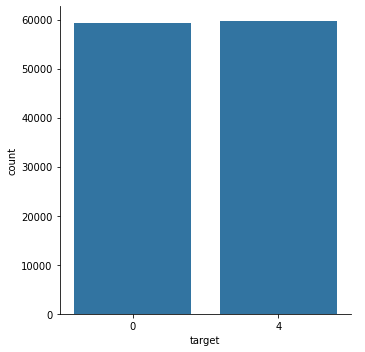

In [5]:
sns.catplot(x = 'target', data = sentiment_dataset, kind = 'count')


In [6]:
hateful_dataset = pd.read_csv("hateful_sentiment.csv")

In [7]:
hateful_dataset.head()

,Content,Label,Content_int
0,retweet to the rejects who constantly call my ...,1,"[146715, 1761, 7, 3, 22587, 67, 6768, 472, 129..."
1,i purpose that whatever attack everyone who ca...,1,"[146715, 80, 4226, 28, 220, 1347, 1568, 67, 65..."
2,are you fucking kidding me you deserve to fuck...,1,"[146715, 154, 26, 69, 1361, 78, 26, 6610, 7, 6..."
3,retweet i am not racist and i am not sexist i ...,1,"[146715, 1761, 80, 81, 76, 1723, 111, 80, 81, ..."
4,just imagine if the two million spent on the s...,1,"[146715, 14, 925, 204, 3, 672, 462, 5271, 9, 3..."


In [8]:
hateful_dataset = hateful_dataset[["Content", "Label"]]
hateful_dataset = hateful_dataset.rename(columns = {"Content": "text", "Label": "target"})
hateful_dataset["target"] = 2

hateful_dataset.head()

,text,target
0,retweet to the rejects who constantly call my ...,2
1,i purpose that whatever attack everyone who ca...,2
2,are you fucking kidding me you deserve to fuck...,2
3,retweet i am not racist and i am not sexist i ...,2
4,just imagine if the two million spent on the s...,2


In [9]:
sentiment_dataset = sentiment_dataset[["text", "target"]]
sentiment_dataset.head()

,text,target
0,I'm off too bed. I gotta wake up hella early t...,0
1,I havent been able to listen to it yet My spe...,0
2,now remembers why solving a relatively big equ...,0
3,"Ate too much, feel sick",0
4,Tried to purchase a parked domain through GoDa...,0


In [10]:
sentiment_dataset.loc[sentiment_dataset['target']==4, 'target'] = 1
sentiment_dataset.loc[sentiment_dataset['target']==0, 'target'] = 0
# 0 - negative, 1 - positive, 2 - hateful

In [11]:
sentiment_dataset = pd.concat([sentiment_dataset, hateful_dataset], ignore_index= True)

In [12]:
sentiment_dataset.head()

,text,target
0,I'm off too bed. I gotta wake up hella early t...,0
1,I havent been able to listen to it yet My spe...,0
2,now remembers why solving a relatively big equ...,0
3,"Ate too much, feel sick",0
4,Tried to purchase a parked domain through GoDa...,0


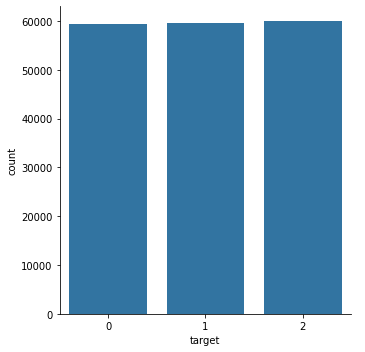

In [13]:
sns.catplot(x = 'target', data = sentiment_dataset, kind = 'count')

In [14]:
sentiment_dataset['target'].value_counts()

target
2    60000
1    59700
0    59300
Name: count, dtype: int64

In [15]:
sentiment_dataset.isnull().sum()

text      0
target    0
dtype: int64

In [16]:
X = sentiment_dataset['text']
y = sentiment_dataset['target']

In [17]:
def set_seed(seed=42):
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

CNN

In [18]:
# Tokenizacja i czyszczenie tekstu
def tokenize(text):
    text = text.lower()
    text = re.sub(r"[^a-zA-Z0-9\s]", "", text)
    return text.split() # podział na tokeny (słowa) po spacjach

# Tworzenie słownika
all_tokens = [token for text in sentiment_dataset['text'] for token in tokenize(text)]
vocab = {word: i+2 for i, (word, _) in enumerate(Counter(all_tokens).most_common(10000))}
vocab['<PAD>'] = 0 # do wyrównania długości sekwencji
vocab['<UNK>'] = 1 # dla słów nieznanych

# tokenizacja tekstu, zamiana słów na indeksy słownika, jeśli nie ma słowa w słowniku -> wartość 1
def encode(text):
    return [vocab.get(token, 1) for token in tokenize(text)]

In [19]:
# Dataset
class TextDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = [torch.tensor(encode(text)) for text in texts]
        self.labels = torch.tensor(labels, dtype=torch.long)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.texts[idx], self.labels[idx]

# Funkcja padding collate
def collate_fn(batch):
    texts, labels = zip(*batch) # rozdzielenie par na 2 listy
    texts_padded = pad_sequence(texts, batch_first=True, padding_value=0) # wyrównanie długości sekwencji
    return texts_padded, torch.tensor(labels)

In [20]:
# Model CNN
class TextCNN(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_classes):
        super(TextCNN, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0) # zmiana indeksów słów w wektory
        self.conv1 = nn.Conv1d(embed_dim, 100, kernel_size=3)
        self.relu = nn.ReLU()
        self.pool = nn.AdaptiveMaxPool1d(1)
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(100, num_classes)

    def forward(self, x):
        x = self.embedding(x) 
        x = x.permute(0, 2, 1)
        x = self.relu(self.conv1(x))
        x = self.dropout(x) 
        x = self.pool(x).squeeze(2)
        return self.fc(x)
    

In [37]:
# Hiperparametry
epochs_num = 4
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = TextCNN(vocab_size=len(vocab), embed_dim=100, num_classes=3).to(device)
embed_dim = 100

param_grid = list(ParameterGrid({
    'learning_rate': [1e-3],
    'batch': [16, 32]
}))

In [38]:
# Podsumowanie modelu
summary(model, input_size=(32, 100), dtypes=[torch.long])

Layer (type:depth-idx)                   Output Shape              Param #
TextCNN                                  [32, 3]                   --
├─Embedding: 1-1                         [32, 100, 100]            1,000,200
├─Conv1d: 1-2                            [32, 100, 98]             30,100
├─ReLU: 1-3                              [32, 100, 98]             --
├─Dropout: 1-4                           [32, 100, 98]             --
├─AdaptiveMaxPool1d: 1-5                 [32, 100, 1]              --
├─Linear: 1-6                            [32, 3]                   303
Total params: 1,030,603
Trainable params: 1,030,603
Non-trainable params: 0
Total mult-adds (M): 126.41
Input size (MB): 0.03
Forward/backward pass size (MB): 5.07
Params size (MB): 4.12
Estimated Total Size (MB): 9.22

In [39]:
# Podział na 5 foldów
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

results = []

def evaluate_model(model, val_loader):
    model.eval()  # Ustawienie modelu w tryb ewaluacji
    true_labels = []
    pred_labels = []
    
    with torch.no_grad():  # Bez obliczania gradientów
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            true_labels.extend(labels.cpu().numpy())
            pred_labels.extend(preds.cpu().numpy())
    
    return true_labels, pred_labels

def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=epochs_num):
    train_loss_history = []
    val_loss_history = []
    train_acc_history = []
    val_acc_history = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct_preds = 0
        total_preds = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct_preds += (preds == labels).sum().item()
            total_preds += labels.size(0)

        avg_train_loss = running_loss / len(train_loader)
        train_acc = correct_preds / total_preds
        train_loss_history.append(avg_train_loss)
        train_acc_history.append(train_acc)

        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, preds = torch.max(outputs, 1)
                val_correct += (preds == labels).sum().item()
                val_total += labels.size(0)

        avg_val_loss = val_loss / len(val_loader)
        val_acc = val_correct / val_total
        val_loss_history.append(avg_val_loss)
        val_acc_history.append(val_acc)

        print(f"Epoch {epoch+1}/{epochs} - Train Loss: {avg_train_loss:.4f} - Val Loss: {avg_val_loss:.4f} - Train Acc: {train_acc:.4f} - Val Acc: {val_acc:.4f}")

    return model, train_loss_history, val_loss_history, train_acc_history, val_acc_history


In [41]:
results = []
best_f1 = 0.0
best_cm = None

for param_idx, params in enumerate(param_grid):
    lr = params['learning_rate']
    batch = params['batch']
    print(f"\n=== Param set {param_idx+1}/{len(param_grid)}: LR={lr}, Batch={batch} ===")

    for fold, (train_idx, val_idx) in enumerate(kf.split(X, y)):
        print(f"\nTraining fold {fold+1}/5...")

        train_texts, val_texts = X.iloc[train_idx], X.iloc[val_idx]
        train_labels, val_labels = y.iloc[train_idx], y.iloc[val_idx]

        train_dataset = TextDataset(train_texts.tolist(), train_labels.tolist())
        val_dataset = TextDataset(val_texts.tolist(), val_labels.tolist())

        train_loader = DataLoader(train_dataset, batch_size=batch, shuffle=True, collate_fn=collate_fn)
        val_loader = DataLoader(val_dataset, batch_size=batch, shuffle=False, collate_fn=collate_fn)

        model = TextCNN(vocab_size=len(vocab), embed_dim=embed_dim, num_classes=3).to(device)
        optimizer = optim.Adam(model.parameters(), lr=lr)
        criterion = nn.CrossEntropyLoss()

        model, train_loss_hist, val_loss_hist, train_acc_hist, val_acc_hist = train_model(
            model, train_loader, val_loader, criterion, optimizer, epochs=epochs_num
        )

        true_labels, pred_labels = evaluate_model(model, val_loader)

        accuracy = accuracy_score(true_labels, pred_labels)
        precision = precision_score(true_labels, pred_labels, average='weighted')
        recall = recall_score(true_labels, pred_labels, average='weighted')
        f1 = f1_score(true_labels, pred_labels, average='weighted')
        cm = confusion_matrix(true_labels, pred_labels)

        results.append({
            "params_id": param_idx + 1,
            "fold": fold + 1,
            "learning_rate": lr,
            "batch": batch,
            "accuracy": accuracy,
            "precision": precision,
            "recall": recall,
            "f1": f1,
            "confusion_matrix": cm
        })

        if f1 > best_f1:
            best_f1 = f1
            best_cm = cm
            torch.save(model.state_dict(), f"best_model_paramset_{param_idx+1}_fold_{fold+1}.pth")



=== Param set 1/2: LR=0.001, Batch=16 ===

Training fold 1/5...
Epoch 1/4 - Train Loss: 0.5500 - Val Loss: 0.4560 - Train Acc: 0.7481 - Val Acc: 0.8132
Epoch 2/4 - Train Loss: 0.4227 - Val Loss: 0.4300 - Train Acc: 0.8144 - Val Acc: 0.8195
Epoch 3/4 - Train Loss: 0.3911 - Val Loss: 0.4103 - Train Acc: 0.8303 - Val Acc: 0.8208
Epoch 4/4 - Train Loss: 0.3742 - Val Loss: 0.4130 - Train Acc: 0.8385 - Val Acc: 0.8229

Training fold 2/5...
Epoch 1/4 - Train Loss: 0.5520 - Val Loss: 0.4567 - Train Acc: 0.7471 - Val Acc: 0.8094
Epoch 2/4 - Train Loss: 0.4230 - Val Loss: 0.4232 - Train Acc: 0.8135 - Val Acc: 0.8204
Epoch 3/4 - Train Loss: 0.3908 - Val Loss: 0.4421 - Train Acc: 0.8305 - Val Acc: 0.8123
Epoch 4/4 - Train Loss: 0.3723 - Val Loss: 0.4180 - Train Acc: 0.8396 - Val Acc: 0.8140

Training fold 3/5...
Epoch 1/4 - Train Loss: 0.5524 - Val Loss: 0.4648 - Train Acc: 0.7460 - Val Acc: 0.8036
Epoch 2/4 - Train Loss: 0.4206 - Val Loss: 0.4522 - Train Acc: 0.8157 - Val Acc: 0.8091
Epoch 3/4 -

In [42]:
import pandas as pd

# Konwersja listy wyników do DataFrame
df_results = pd.DataFrame(results)

# Zapis do pliku CSV
df_results.to_csv("results_grid_search.csv", index=False)

In [43]:
print(df_results)

   params_id  fold  learning_rate  batch  accuracy  precision    recall  \
0          1     1          0.001     16  0.822905   0.825424  0.822905   
1          1     2          0.001     16  0.813966   0.823717  0.813966   
2          1     3          0.001     16  0.821369   0.821117  0.821369   
3          1     4          0.001     16  0.823939   0.821255  0.823939   
4          1     5          0.001     16  0.822598   0.822480  0.822598   
5          2     1          0.001     32  0.831201   0.832890  0.831201   
6          2     2          0.001     32  0.824441   0.825366  0.824441   
7          2     3          0.001     32  0.824106   0.823560  0.824106   
8          2     4          0.001     32  0.824218   0.824854  0.824218   
9          2     5          0.001     32  0.802402   0.822042  0.802402   

         f1                                   confusion_matrix  
0  0.820297  [[9863, 1560, 437], [3508, 7960, 472], [159, 2...  
1  0.810755  [[7358, 4105, 397], [1339, 1023

In [47]:
# Zakładam, że Twój DataFrame nazywa się df_results
best_per_param = df_results.loc[df_results.groupby("params_id")["f1"].idxmax()].reset_index(drop=True)
print(best_per_param)

best_per_param.to_csv("results_grid_search_best.csv", index=False)

   params_id  fold  learning_rate  batch  accuracy  precision    recall  \
0          1     4          0.001     16  0.823939   0.821255  0.823939   
1          2     1          0.001     32  0.831201   0.832890  0.831201   

         f1                                   confusion_matrix  
0  0.822170  [[8836, 2512, 512], [2307, 9045, 588], [149, 2...  
1  0.831183  [[9623, 2034, 203], [3017, 8681, 242], [248, 2...  


In [11]:
import pandas as pd
import scikit_posthocs as sp
from scipy.stats import friedmanchisquare

# Przykładowe dane: wyniki z 5 foldów dla 3 konfiguracji hiperparametrów
metrics_all = {
    "accuracy": {
        "config_A": [0.831, 0.828, 0.827, 0.831, 0.823],
        "config_B": [0.835, 0.830, 0.829, 0.834, 0.825],
        "config_C": [0.840, 0.832, 0.831, 0.836, 0.827],
    },
    "f1": {
        "config_A": [0.831, 0.827, 0.827, 0.831, 0.821],
        "config_B": [0.835, 0.829, 0.829, 0.834, 0.824],
        "config_C": [0.839, 0.831, 0.831, 0.837, 0.826],
    }
    # i inne metryki
}


for metric in metrics_all:
    print(f"\n === {metric.upper()} - Test Friedmana ===")

    df = pd.DataFrame(metrics_all[metric])
    print(f"\n Średnie wyniki {metric}:")
    print(df.mean().sort_values(ascending=False).round(4))

    # Test Friedmana
    stat, p = friedmanchisquare(*[df[col] for col in df.columns])
    print(f"\n Statystyka Friedmana: {stat:.4f}, p-wartość: {p:.4f}")

    if p < 0.05:
        print(" Istnieje istotna różnica między konfiguracjami")
    else:
        print(" Brak statystycznie istotnych różnic między konfiguracjami.")



 === ACCURACY - Test Friedmana ===

 Średnie wyniki accuracy:
config_C    0.8332
config_B    0.8306
config_A    0.8280
dtype: float64

 Statystyka Friedmana: 10.0000, p-wartość: 0.0067
 Istnieje istotna różnica między konfiguracjami

 === F1 - Test Friedmana ===

 Średnie wyniki f1:
config_C    0.8328
config_B    0.8302
config_A    0.8274
dtype: float64

 Statystyka Friedmana: 10.0000, p-wartość: 0.0067
 Istnieje istotna różnica między konfiguracjami
